In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import os
import json
import pandas as pd
import glob
import numpy as np
import sys
import time
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from collections import Counter
import pylab as py
import img_scale
import googlemaps
import pickle
from matplotlib import colors


## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

%matplotlib inline



In [3]:
# Find local maxima
def find_local_max(inarr,win=3,style='mode',level=3,**kwargs):
    """
    Find the local maxima in an array.
    
    The input array should be a (NxN) numpy array.
    
    A window of size (win)x(win) is used.
    Window size win needs to be an odd number
    to have a defined center pixel. If win is even, 
    it is autamtically increased by +1.
    
    The output is a mask of size equal to the input array 
    (NxN) with 0, unless a pixel is identified as a maximum.
    
    The maxima are evaluated base on 'style' using 'level'. 
    E.g., for 'style=mode' and 'level=3', a local maximum if 
    found is retained if its value is 3 times the mode of the
    image.
    """
    # check input
    if win%2 == 0:
        win += 1
    # create empty mask
    shp = inarr.shape
    mask = np.zeros(shape=shp)
    # central index of window
    win_idx = int(np.floor(win/2.)) 
    cen_idx = (win_idx,win_idx)
    win_mask = np.zeros(shape=(win,win))
    win_mask[cen_idx] = 1
    comp_mask = win_mask == 0
    val_mask = win_mask == 1
    xlen = len(inarr[:,0])
    ylen = len(inarr[:,1])
    # determine more in array
    inarr_ravel = inarr.ravel()
    tmp_list = np.ndarray.tolist(inarr_ravel)
    if style == 'mean':
        tmp_mode = np.mean(inarr_ravel)
        print('Using MEAN for cutoff: ', tmp_mode)
    elif style == 'median':
        tmp_mode = np.median(inarr_ravel)
        print('Using MEDIAN for cutoff: ', tmp_mode)
    elif style == 'bkg':
        tmp_mode = find_background(inarr,**kwargs)
        print('Using BKG for cutoff: ', tmp_mode)
    else:
        tmp_mode = Counter(tmp_list).most_common(1)[0][0]
        print('Using MODE for cutoff: ', tmp_mode)
    cutoff = level*tmp_mode
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            sub_arr = inarr[xidx-win_idx:xidx+win_idx+1,yidx-win_idx:yidx+win_idx+1]
            if sub_arr.shape != (win,win):
                pass
            else:
                comp_vals = sub_arr[comp_mask]
                mid_val = sub_arr[val_mask]
                check = [False if x < mid_val else True for x in comp_vals]
                if (sum(check) == 0) and (mid_val > cutoff):
                    mask[xidx,yidx] = int(1)
    final_mask = mask == 1
    return final_mask, cutoff
        

In [4]:
# Determine background
def find_background(inarr,patch=3,method='median',n_samples=50):
    """
    Find the background value in a 2D array.
    
    Randomly sample the array at 'n_samples' locations. Take 
    metric as set by 'style' within square region with side length 
    defined by 'win'. 
    
    Returns background value of array.
    """
    xdim = inarr.shape[0]
    ydim = inarr.shape[1]
    xidx = np.random.randint(0,xdim-1,n_samples)
    yidx = np.random.randint(0,ydim-1,n_samples)
    coords = zip(xidx,yidx)
    bkg_vec = []
    for idx,coord in enumerate(coords):
        tmp_patch = inarr[coord[0]-patch:coord[0]+patch,coord[1]-patch:coord[1]+patch]
        try:
            if method == 'mean':
                tmp_val = np.mean(tmp_patch)
            else:
                tmp_val = np.median(tmp_patch)
            bkg_vec.append(tmp_val)
        except:
            pass
    if method == 'mean':
        return np.nanmean(bkg_vec)
    else:
        return np.nanmedian(bkg_vec)


In [5]:
# Grab private data
if __name__ == "__main__":
    google_api_key =  os.environ['GOOGLE_API_KEY']
gmaps = googlemaps.Client(key=google_api_key)


KeyError: 'GOOGLE_API_KEY'

In [6]:
# Get CA coordinates
try:
    x_coords
    y_coords
except:
    infile = os.path.join('..','..','data','ca_shape.csv')
    ca_shape = pd.read_csv(infile)
    x_coords = ca_shape['longitude'].tolist()
    y_coords = ca_shape['latitude'].tolist()


In [7]:
# import cleaned and pickled dataframe
try:
    flickr_all_clean.shape
except:
    start_time = time.time()
    flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
    print("--- %s seconds ---" % (time.time() - start_time))


--- 20.8274619579 seconds ---


# Plot data as individual data points

(494, 8)
--- 3.52731513977 seconds ---


<function matplotlib.pyplot.show>

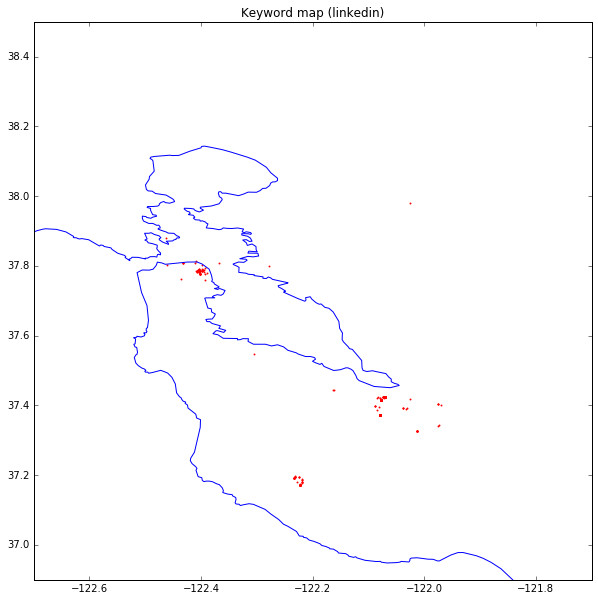

In [8]:
# If 'keyword_vec = ['']', run the KDE on all images in df and skip peak finding.

keyword_vec = ['linkedin']#,'skateboard','toyota']

# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#
start_time = time.time()
#
for ikey,keyword in enumerate(keyword_vec):
    # Select subset based on keyword
    if len(keyword.strip()) == 0:
        df = copy.copy(flickr_all_clean)
    else:
        df = flickr_all_clean[flickr_all_clean['title_tags']
                              .str.contains(keyword, na=False)]
    print(df.shape)
    # Extract long/lat and combine into 2d array
    limit_lng = [-122.4,-122]
    limit_lat = [37.4,37.7]
    #
    limit_lng = [-122.7,-121.7]
    limit_lat = [36.9,38.5]
    #
    #limit_lat = []
    #
    if len(limit_lng) != 0 and len(limit_lat) != 0:
        yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                        (df['longitude'] < limit_lng[1]) & 
                                        (df['latitude'] > limit_lat[0]) & 
                                        (df['latitude'] < limit_lat[1])].tolist()))

        xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                       (df['longitude'] < limit_lng[1]) & 
                                       (df['latitude'] > limit_lat[0]) & 
                                       (df['latitude'] < limit_lat[1])].tolist()))
    else:
        yin = np.array((df['longitude'][(df['longitude'] != 0.0) & 
                                        (df['latitude'] != 0.0)].tolist()))
        xin = np.array((df['latitude'][(df['longitude'] != 0.0) & 
                                       (df['latitude'] != 0.0)].tolist()))

    XY = np.vstack([yin.ravel(), xin.ravel()]).T
    # Run KDE
    lng_max = max(yin)
    lng_min = min(yin)
    lat_max = max(xin)
    lat_min = min(xin)
    lng_max = limit_lng[0]
    lng_min = limit_lng[1]
    lat_max = limit_lat[0]
    lat_min = limit_lat[1]
    
    plt.scatter(yin,xin,.8,color='red')
    if len(limit_lng) != 0 and len(limit_lat) != 0:
        plt.xlim(limit_lng[0],limit_lng[1])
        plt.ylim(limit_lat[0],limit_lat[1]) 
    else:
        plt.xlim(-123,-121.5)
        plt.ylim(36.8,38.5) 
        
    # plot titles
    plt.title('Keyword map (' + keyword +')')
print("--- %s seconds ---" % (time.time() - start_time))
outname = os.path.join('img/data_only_'+keyword+'.png')
plt.savefig(outname,bbox_inches='tight')
plt.show     



(494, 8)
Using MEDIAN for cutoff:  4.18194115862e-36
--- 3.51648306847 seconds ---


<function matplotlib.pyplot.show>

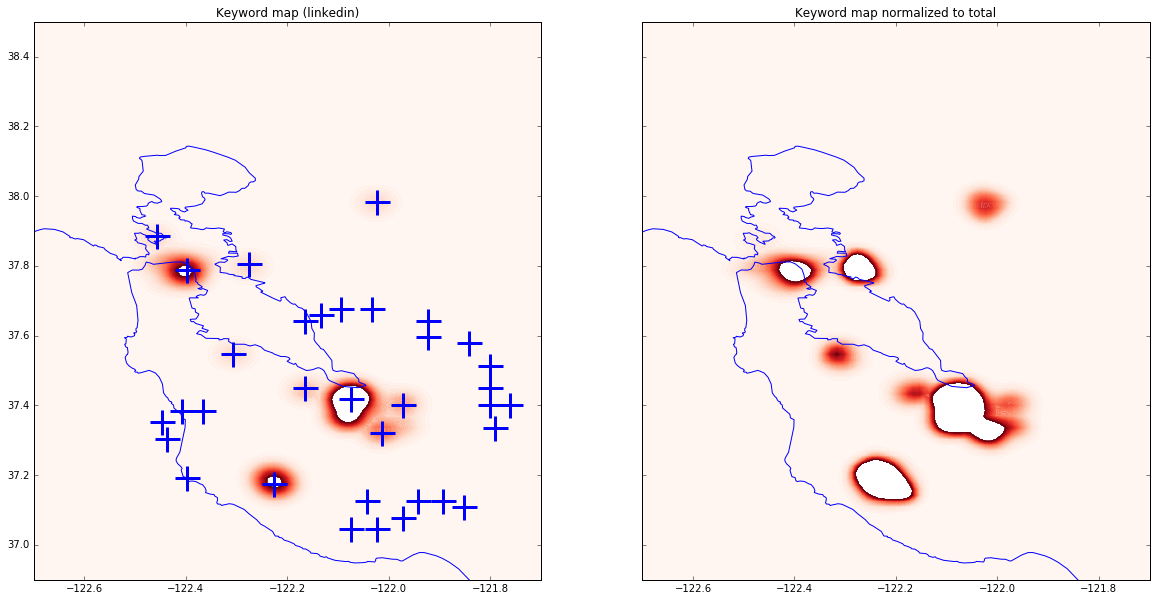

In [12]:
# If 'keyword_vec = ['']', run the KDE on all images in df and skip peak finding.

keyword_vec = ['linkedin']#,'skateboard','toyota']

# create figure
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,10))
#plt.figure(figsize=(20,10))
# plot CA outline
ax1.plot(x_coords,y_coords)
ax2.plot(x_coords,y_coords)


start_time = time.time()

for ikey,keyword in enumerate(keyword_vec):
    # Select subset based on keyword
    if len(keyword.strip()) == 0:
        df = copy.copy(flickr_all_clean)
    else:
        df = flickr_all_clean[flickr_all_clean['title_tags']
                              .str.contains(keyword, na=False)]
    print(df.shape)
    # Extract long/lat and combine into 2d array
    limit_lng = [-122.4,-122]
    limit_lat = [37.4,37.7]
    #
    limit_lng = [-122.7,-121.7]
    limit_lat = [36.9,38.5]
    #
    #limit_lat = []
    #
    if len(limit_lng) != 0 and len(limit_lat) != 0:
        yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                        (df['longitude'] < limit_lng[1]) & 
                                        (df['latitude'] > limit_lat[0]) & 
                                        (df['latitude'] < limit_lat[1])].tolist()))

        xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                       (df['longitude'] < limit_lng[1]) & 
                                       (df['latitude'] > limit_lat[0]) & 
                                       (df['latitude'] < limit_lat[1])].tolist()))
    else:
        yin = np.array((df['longitude'][(df['longitude'] != 0.0) & 
                                        (df['latitude'] != 0.0)].tolist()))
        xin = np.array((df['latitude'][(df['longitude'] != 0.0) & 
                                       (df['latitude'] != 0.0)].tolist()))

    XY = np.vstack([yin.ravel(), xin.ravel()]).T
    # Run KDE
    lng_max = max(yin)
    lng_min = min(yin)
    lat_max = max(xin)
    lat_min = min(xin)
    lng_max = limit_lng[0]
    lng_min = limit_lng[1]
    lat_max = limit_lat[0]
    lat_min = limit_lat[1]

    # Set up the data grid for the contour plot
    xgrid = np.linspace(lng_min,lng_max,100)
    ygrid = np.linspace(lat_min,lat_max,100)
    X, Y = np.meshgrid(xgrid, ygrid)
    #
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    xy *= np.pi / 180.
    #
    Xtrain = np.vstack([xin,yin]).T
    Xtrain *= np.pi / 180.  # Convert lat/long to radians
    #
    kde = KernelDensity(bandwidth=0.0003, algorithm='ball_tree',rtol=1e-4)
    kde.fit(Xtrain)
    #
    Z = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    tmp_reload = pickle.load( open( "kde_all.pkl", "rb" ) )
    X_all = tmp_reload['X']
    Y_all = tmp_reload['Y']
    Z_all = tmp_reload['Z']

    Z_div = np.divide(Z,Z_all)
    if len(keyword.strip()) > 0:
        # Find local maxima in KDE map
        level = 1
        method = 'median'

        local_maxima_map, cutoff = find_local_max(Z,win=5,style='median', 
                                                  level=level,patch=5,method=method,
                                                  n_samples=50)
        xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
                              Y.reshape(local_maxima_map.shape)[local_maxima_map])).T
        z_maxima = np.array((Z.reshape(local_maxima_map.shape)[local_maxima_map])).T
        z_all_maxima = np.array((Z_all.reshape(local_maxima_map.shape)[local_maxima_map])).T
        z_maxima_ratio = np.divide(z_maxima,z_all_maxima)
        # Save results in dictionary
        results_dict = {}
        results_dict['longitude'] = xy_maxima[:,0].tolist()
        results_dict['latitude']  = xy_maxima[:,1].tolist()
        results_dict['max_val'] = z_maxima.tolist()
        results_dict['max_val_all'] = z_all_maxima.tolist()
        results_dict['max_val_ratio'] = z_maxima_ratio.tolist()
        # get zip code for peak coordinates from google geocode API
#         zip_list = []
#         for coord in xy_maxima:
#             geocode_result = gmaps.geocode("{},{}".format(coord[1],coord[0]))
#             tmp_zip = [str(s['long_name']) for s in geocode_result[0]
#                        ['address_components'] if 'postal_code' in s['types']]
#             zip_list.append(tmp_zip)
#         results_dict['zip_code'] = zip_list
    # set levels for contours
    levels = np.linspace(0, np.sqrt(Z.max())/3, 50)
    levels_div = np.linspace(0, np.log10(Z_div.max()), 50)

    #levels = np.linspace(0, 8, 50)

    # Set values below bkg to NaN, contourf will convert these to masked
    #Z[np.sqrt(Z) < cutoff] = np.nan
    # plot contours of the density
    # levels = np.linspace(0, np.log10(Z.max()), 50)

    ax1.contourf(X, Y, np.sqrt(Z), levels=levels, 
                 cmap=plt.cm.Reds,label=keyword,alpha=0.8)
    if len(keyword.strip()) > 0:

        #
        ax1.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', markersize=25,
                 markeredgewidth=3,markeredgecolor='b')
    ax2.contourf(X, Y, np.sqrt(Z_div), levels=levels_div, 
                 cmap=plt.cm.Reds,label=keyword,alpha=0.8)

#     if len(keyword.strip()) > 0:

#         ax2.plot(xy_maxima_div[:, 0], xy_maxima_div[:, 1],'+', markersize=15,
#                  markeredgewidth=3,markeredgecolor='olive')

#     else:
#         # svae full map to pickle
#         tmp_save = {'X': X, 'Y': Y, 'Z': Z}
#         pickle.dump(tmp_save,open( "kde_all.pkl", "wb" ))
    #
    if len(limit_lng) != 0 and len(limit_lat) != 0:
        ax1.set_xlim(limit_lng[0],limit_lng[1])
        ax1.set_ylim(limit_lat[0],limit_lat[1]) 
        ax2.set_xlim(limit_lng[0],limit_lng[1])
        ax2.set_ylim(limit_lat[0],limit_lat[1]) 

    else:
        ax1.set_xlim(-123,-121.5)
        ax1.set_ylim(36.8,38.5) 
        
    # plot titles
    ax1.set_title('Keyword map (' + keyword +')')
    ax2.set_title('Keyword map normalized to total')

print("--- %s seconds ---" % (time.time() - start_time))

plt.show     


# Fit gaussians to KDE peaks 

-121.990372091 36.9637549091 26511.3535376
[  2.72352007e+04  -1.22003233e+02   3.69612740e+01   2.95147866e-02
   1.64614292e-02  -5.12786915e-02   2.51438637e+03]
-121.927158061 37.2872206364 13549.2765362
[  9.84149577e+03  -1.22036125e+02   3.73984235e+01   2.17070662e-01
   2.57435342e-02  -5.61293288e+01   2.33874316e+03]
-121.882005182 37.3294118182 25721.9683411
[  2.02953834e+04  -1.21889282e+02   3.73274923e+01   3.35234728e-02
   2.07024551e-02  -5.75812866e-01   2.51023319e+03]
-121.972310939 37.3997304545 28109.3846759
[  2.24624913e+04  -1.21975147e+02   3.73993328e+01   2.60899722e-02
   1.70977095e-02  -2.08136415e-01   2.53027402e+03]
-122.170983606 37.4419216364 24932.2474108
[  2.20537367e+04  -1.22168811e+02   3.74485515e+01   2.34941279e-02
   2.02968390e-02   3.59765427e-01   2.52781819e+03]
-122.261289364 37.4981765455 15239.8500079
[  3.22746537e+05  -1.22409048e+02   3.77698530e+01   2.96933368e-02
   2.43531875e-02   3.40615447e+00   1.42522217e+03]
-122.30644

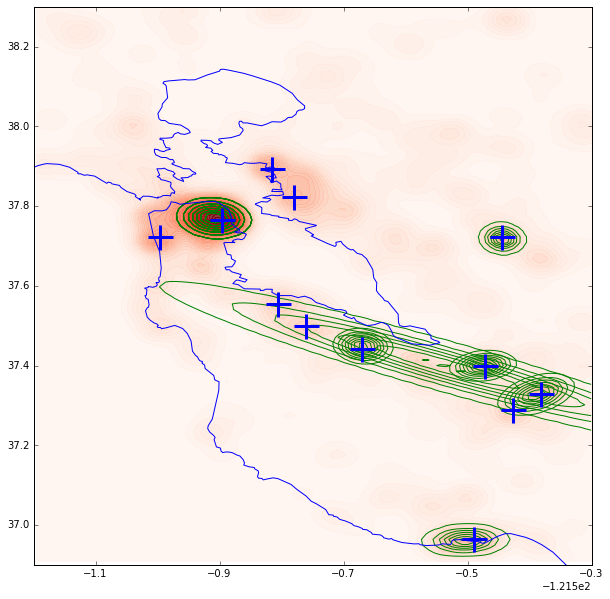

In [106]:
import scipy.optimize as opt
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

seed_coords = xy_maxima
seed_values = np.array(Z.reshape(local_maxima_map.shape)[local_maxima_map].T)

coords = np.array((X, Y)).ravel()
data = Z.ravel()

# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)

plt.contourf(X, Y, np.sqrt(Z), levels=levels, 
             cmap=col_map[ikey],label=keyword,alpha=0.8)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', markersize=25,
         markeredgewidth=3,markeredgecolor='b')
plt.xlim(limit_lng[0],limit_lng[1])
plt.ylim(limit_lat[0],limit_lat[1]) 



# ax.hold(True)
# ax.imshow(data.reshape(Z.shape), cmap=plt.cm.jet, origin='bottom',
#     extent=(X.min(), X.max(), Y.min(), Y.max()))



for idx,value in enumerate(seed_values):
    x_coord = seed_coords[idx,0]
    y_coord = seed_coords[idx,1]
    z_value = value
#     print(x_coord,y_coord,z_value)
    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (z_value,x_coord,y_coord,0.01,0.01,0,5000)
    popt, pcov = opt.curve_fit(twoD_Gaussian, (X, Y), data, p0=initial_guess)
#     print(popt)
    data_fitted = twoD_Gaussian((X, Y), *popt)
    plt.contour(X, Y, data_fitted.reshape(Z.shape), 8, colors='g')

plt.show()

    
    


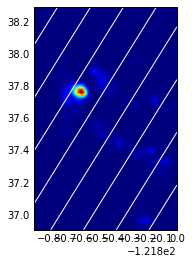

In [76]:
data_fitted = twoD_Gaussian((X, Y), *popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(data.reshape(Z.shape), cmap=plt.cm.jet, origin='bottom',
    extent=(X.min(), X.max(), Y.min(), Y.max()))
ax.contour(X, Y, data_fitted.reshape(Z.shape), 8, colors='w')
plt.show()
